# Tutorial for TracInCP method

This tutorial demonstrates how to apply the [TracInCP](https://arxiv.org/pdf/2002.08484.pdf) algorithm for influential examples interpretability from the Captum library.  TracInCP calculates the influence score of a given training example on a given test example, which roughly speaking, represents how much higher the loss for the given test example would be if the given training example were removed from the training dataset, and the model re-trained.  This functionality can be leveraged towards the following 2 use cases:
1. For a single test example, identifying its influential examples.  These are the training examples with the most positive influence scores (proponents) and the training examples with the most negative influence scores (opponents).  
2. Identifying mis-labelled data, i.e. examples in the training data whose "ground-truth" label is actually incorrect.  The influence score of a mis-labelled example on itself (i.e. self influence score) will tend to be high.  Thus to find mis-labelled examples, one can examine examples in order of decreasing self influence score.


TracInCP can be used for any trained Pytorch model for which several model checkpoints are available.

  
  **Note:** Before running this tutorial, please do the following:
  - install Captum.
  - install the torchvision, and matplotlib packages.
  - install the [Annoy](https://github.com/spotify/annoy) Python module.

## Overview of different implementations of the TracInCP method
Currently, Captum offers 3 implementations, all of which implement the same API.  More specifically, they define an `influence` method, which can be used in 3 different modes:
- self influence mode: calculates the self influence scores for all examples in the training dataset.
- influence score mode: given a batch of test examples, calculates the influence score of every example in the training dataset on every test example.
- top-k most influential mode: given a batch of test examples, calculates either the proponents or opponents of every test example, as well as their corresponding influence scores.

The 3 different implementations are defined in the following classes:
- `TracInCP`: considers gradients in all specified layers when computing influence scores.  Specifying many layers will slow the execution of all 3 modes.
- `TracInCPFast`: In Appendix F of the TracIn paper, they show that if considering only gradients in the last fully-connected layer when computing influence scores, the computation can be done more quickly than naively applying backprop to compute gradients, using a computational trick.  `TracInCPFast` computes influence scores, considering only the last fully-connected layer, using that trick.  `TracInCPFast` is useful if you want to reduce the time and memory usage, relative to `TracInCP`.
- `TracInCPFastRandProj`:  The previous two classes were not meant for "interactive" use, because each call to `influence` in influence score mode or top-k most influential mode takes time proportional to the training dataset size.  On the other hand, `TracInCPFastRandProj` enables "interactive" use, i.e. constant-time calls to `influence` for those two modes.  The price we pay is that in `TracInCPFastRandProj.__init__`, pre-processing is done to store embeddings related to each training example into a nearest-neighbors data structure.  This pre-processing takes both time and memory proportional to training dataset size.  Furthermore, random projections can be applied to reduce memory usage, at the cost of the influence scores used in those two modes to be only approximately correct.  Like `TracInCPFast`, this class only considers gradients in the last fully-connected layer, and is useful if you want to reduce the time and memory usage, relative to `TracInCP`.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import datetime
import glob
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from captum.influence import TracInCP, TracInCPFast, TracInCPFastRandProj
from captum.influence._utils.common import _load_flexible_state_dict
from sklearn.metrics import auc, roc_curve
from torch.utils.data import DataLoader, Dataset, Subset


warnings.filterwarnings("ignore")

# Identifying Influential Examples
First, we will illustrate the ability of TracInCP to identify influential examples, i.e. use the `influence` method in "top-k most influential" mode.  To do this, we need 3 components:
- A Pytorch model, `net`.
- A Pytorch `Dataset` used to train `net`.  For this we will use `correct_dataset`, the original CIFAR-10 training split.
- A Pytorch `Dataset` from which to select test examples, `test_dataset`.  For this, we will use the original CIFAR-10 validation split.  This will also be useful for monitoring training.
- Checkpoints from training `net` with `correct_dataset`.  We will train and save checkpoints.

#### Define `net`
We will use a relatively simple model from the following tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

We first define the architecture of `net`

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

In the cell below, we initialize `net`.

In [4]:
net = Net()

Because both are image datasets we will first define the `normalize` and `inverse_normalize` transforms to transform from image to input, and input to image, respectively.

In [5]:
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
inverse_normalize = transforms.Compose([ 
    transforms.Normalize(mean = [0., 0., 0.], std = [1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize(mean = [-0.5, -0.5, -0.5], std = [1., 1., 1.]), 
])

#### Define `correct_dataset`

In [ ]:
correct_dataset_path = "data/cifar_10"
correct_dataset = torchvision.datasets.CIFAR10(root=correct_dataset_path, train=True, download=True, transform=normalize)

#### Define `test_dataset`
This will be the same as `correct_dataset`, so that it shares the same path and transform.  The only difference is that that it uses the validation split

In [7]:
test_dataset = torchvision.datasets.CIFAR10(root=correct_dataset_path, train=False, download=True, transform=normalize)

Files already downloaded and verified


#### Obtain checkpoints by training
We will obtain checkpoints by training `net` for 26 epochs on `correct_dataset`.  In general, there should be at least 5 checkpoints, and they can be evenly spaced throughout training, or better yet, be for epochs where the loss decreased a lot.


We first define a training function, which is copied from the above tutorial

In [8]:
def train(net, num_epochs, train_dataloader, test_dataloader, checkpoints_dir, save_every):

    start_time = datetime.datetime.now()

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        epoch_loss = 0.0
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i + 1) % 100 == 0:  # print every 100 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 100))
                epoch_loss += running_loss
                running_loss = 0.0

        if epoch % save_every == 0:
            checkpoint_name = "-".join(["checkpoint", str(epoch) + ".pt"])
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": net.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": epoch_loss,
                },
                os.path.join(checkpoints_dir, checkpoint_name),
            )

        # Calcualate validation accuracy
        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in test_dataloader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print("Accuracy of the network on test set at epoch %d: %d %%" % (epoch, 100 * correct / total))

    total_minutes = (datetime.datetime.now() - start_time).total_seconds() / 60.0
    print("Finished training in %.2f minutes" % total_minutes)

We then define the folder to save checkpoints in.  We will need this folder later to run TracInCP algorithms.

In [9]:
correct_dataset_checkpoints_dir = os.path.join("checkpoints", "cifar_10_correct_dataset")

Finally, we train the model, converting `correct_dataset` and `test_dataset` into `DataLoader`s, and saving every 5-th checkpoint.
For this tutorial, we have saved the checkpoints from this training on AWS S3, and you can just download those checkpoints instead of doing time-intensive training.  If you want to do training yourself, please set the `do_training` flag in the next cell to `True`.

In [ ]:
num_epochs = 26
do_training = False # change to `True` if you want to do training
if do_training:
    train(net, num_epochs, DataLoader(correct_dataset, batch_size=128, shuffle=True), DataLoader(test_dataset, batch_size=128, shuffle=True), correct_dataset_checkpoints_dir, save_every=5)
elif not os.path.exists(correct_dataset_checkpoints_dir): 
    # this should download the zipped folder of checkpoints from the S3 bucket
    # then unzip the folder to produce checkpoints in the folder `checkpoints/cifar_10_correct_dataset`
    # this is done if checkpoints do not already exist in the folder
    # if the below commands do not work, please manually download and unzip the folder to produce checkpoints in that folder
    os.makedirs(correct_dataset_checkpoints_dir)
    !wget https://pytorch.s3.amazonaws.com/models/captum/influence-tutorials/cifar_10_correct_dataset.zip -O checkpoints/cifar_10_correct_dataset.zip
    !unzip -o checkpoints/cifar_10_correct_dataset.zip -d checkpoints

We define the list of checkpoints, `correct_dataset_checkpoint_paths`, to be all checkpoints from training.

In [11]:
correct_dataset_checkpoint_paths = glob.glob(os.path.join(correct_dataset_checkpoints_dir, "*.pt"))

We also define a function that loads a given checkpoint into a given model.  This will be useful immediately, as well as for use in all TracInCP implementations.  When used in TracInCP implementations, this function should return the learning rate at the checkpoint.  However, if that learning rate is not available, it is safe to simply return 1, as we do, because it turns out TracInCP implementations are not sensitive to that learning rate.

In [12]:
def checkpoints_load_func(net, path):
    _load_flexible_state_dict(net, path, keyname="model_state_dict")
    return 1.

We first load `net` with the last checkpoint so that the predictions we make in the next cell will be for the trained model.  We save this last checkpoint as `correct_dataset_final_checkpoint`, because it turns out we will re-use this checkpoint later on.

In [13]:
correct_dataset_final_checkpoint = os.path.join(correct_dataset_checkpoints_dir, "-".join(['checkpoint', str(num_epochs - 1) + '.pt']))
checkpoints_load_func(net, correct_dataset_final_checkpoint)

1.0

Now, we define `test_examples_batch`, the batch of test examples to identify influential examples for, and also store the correct as well as predicted labels.

In [14]:
test_examples_indices = [0,1,2,3]
test_examples_batch = torch.stack([test_dataset[i][0] for i in test_examples_indices])
test_examples_predicted_probs, test_examples_predicted_labels = torch.max(F.softmax(net(test_examples_batch), dim=1), dim=1)
test_examples_true_labels = torch.Tensor([test_dataset[i][1] for i in test_examples_indices]).long()

#### Choosing the TracInCP implementation to use
Recall from above that there are several implementations of the TracInCP algorithm.  In particular, `TracInCP` is more time and memory intensive than `TracInCPFast` and `TracInCPFastRandProj`.  For this tutorial, to save time, we will only use `TracInCPFast` and `TracInCPFastRandProj.`

To choose between `TracInCPFast` and `TracInCPFastRandProj`, recall that `TracInCPFastRandProj` is suitable for "interactive" use, when multiple calls to use the `influence` method in "influence score" and "top-k most influential" mode will be made.  In return for the "interactive" use capability, `TracInCPFastRandProj` requires an initial pre-processing, which can be both time and memory intensive.  On the other hand, `TracInCPFast` does not support "interactive" use, but avoids the initial pre-processing.

#### Defining the `TracInCPFast` instance
We will first illustrate the use of `TracInCPFast`, to avoid the initial pre-processing (since we will only call the `influence` method once, we will not be taking advantage of "interactive" use capability).

To fully define the `TracInCPFast` implementation, several more parameters also need to be defined:
- `final_fc_layer`: a reference or the name of the last fully-connected layer whose gradients will be used to calculate influence scores.  This must be the last layer.
- `loss_fn`: The loss function used in training.
- `batch_size`:  The batch size of training data used for calculating influence scores.  It does not affect the actual influence scores computed, but can affect the computational efficiency.  In particular, the fewer batches needed to iterate through the training data, the faster `influence` is in all modes.  This is because `influence` loads model checkpoints once for each batch.  So `batch_size` should be set large, but not too large (or else the batches will not fit in memory).
- `vectorize`: Whether to use an experimental feature accelerating Jacobian computation.  Only available in PyTorch version >1.6.

We are now ready to create the `TracInCPFast` instance

In [15]:
tracin_cp_fast = TracInCPFast(
    model=net,
    final_fc_layer=list(net.children())[-1],
    influence_src_dataset=correct_dataset,
    checkpoints=correct_dataset_checkpoint_paths,
    checkpoints_load_func=checkpoints_load_func,
    loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    batch_size=2048,
    vectorize=False,
)

#### Compute the proponents / opponents using `TracInCPFast`
Now, we call the `influence` method of `tracin_cp_fast` to compute the influential examples of the test examples in `test_examples_batch`.  We need to specify whether we want proponents or opponents via the `proponents` boolean argument, and how many influential examples to return per test example via the `k` argument.  Note that `k` must be specified.  Otherwise, the "influence score" mode will be run.  This call should take < 2 minutes.

This call returns a `namedtuple` with ordered elements `(indices, influence_scores)`.  `indices` is a 2D tensor of shape `(test_batch_size, k)`, where `test_batch_size` is the number of test examples in `test_examples_batch`.  `influence_scores` is of the same shape, but stores the influence scores of the proponents / opponents for each test example in sorted order.  For example, if `proponents` is `True`, `influence_scores[i][j]` is the influence score of the training example with the `j`-th most positive influence score on test example `i`.

In [16]:
k = 10
start_time = datetime.datetime.now()
proponents_indices, proponents_influence_scores = tracin_cp_fast.influence(
    test_examples_batch, test_examples_true_labels, k=k, proponents=True
)
opponents_indices, opponents_influence_scores = tracin_cp_fast.influence(
    test_examples_batch, test_examples_true_labels, k=k, proponents=False
)
total_minutes = (datetime.datetime.now() - start_time).total_seconds() / 60.0
print(
    "Computed proponents / opponents over a dataset of %d examples in %.2f minutes"
    % (len(correct_dataset), total_minutes)
)

Computed proponents / opponents over a dataset of 50000 examples in 1.22 minutes


#### Define helper functions for displaying results
In order to display results, we define a few helper functions that display a test example, display a set of training examples, as well as a helper transform going from a tensor in the datasets to a tensor suitable for the matplotlib `imshow` function, and a mapping from numerical label (i.e. 4) to class (i.e. "cat").

In [17]:
label_to_class = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

imshow_transform = lambda tensor_in_dataset: inverse_normalize(tensor_in_dataset.squeeze()).permute(1, 2, 0)

def display_test_example(example, true_label, predicted_label, predicted_prob, label_to_class):
    fig, ax = plt.subplots()
    print('true_class:', label_to_class[true_label])
    print('predicted_class:', label_to_class[predicted_label])
    print('predicted_prob', predicted_prob)
    ax.imshow(torch.clip(imshow_transform(example), 0, 1))
    plt.show()
    
def display_training_examples(examples, true_labels, label_to_class, figsize=(10,4)):
    fig = plt.figure(figsize=figsize)
    num_examples = len(examples)
    for i in range(num_examples):
        ax = fig.add_subplot(1, num_examples, i+1)
        ax.imshow(torch.clip(imshow_transform(examples[i]), 0, 1))
        ax.set_title(label_to_class[true_labels[i]])
    plt.show()
    return fig

def display_proponents_and_opponents(test_examples_batch, proponents_indices, opponents_indices, test_examples_true_labels, test_examples_predicted_labels, test_examples_predicted_probs):
    for (
        test_example,
        test_example_proponents,
        test_example_opponents,
        test_example_true_label,
        test_example_predicted_label,
        test_example_predicted_prob,
    ) in zip(
        test_examples_batch,
        proponents_indices,
        opponents_indices,
        test_examples_true_labels,
        test_examples_predicted_labels,
        test_examples_predicted_probs,
    ):

        print("test example:")
        display_test_example(
            test_example,
            test_example_true_label,
            test_example_predicted_label,
            test_example_predicted_prob,
            label_to_class,
        )

        print("proponents:")
        test_example_proponents_tensors, test_example_proponents_labels = zip(
            *[correct_dataset[i] for i in test_example_proponents]
        )
        display_training_examples(
            test_example_proponents_tensors, test_example_proponents_labels, label_to_class, figsize=(20, 8)
        )

        print("opponents:")
        test_example_opponents_tensors, test_example_opponents_labels = zip(
            *[correct_dataset[i] for i in test_example_opponents]
        )
        display_training_examples(
            test_example_opponents_tensors, test_example_opponents_labels, label_to_class, figsize=(20, 8)
        )

#### Display results
We can display, for each test example, its proponents and opponents

test example:
true_class: cat
predicted_class: cat
predicted_prob tensor(0.4126, grad_fn=<UnbindBackward>)


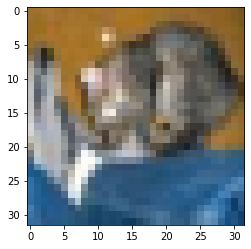

proponents:


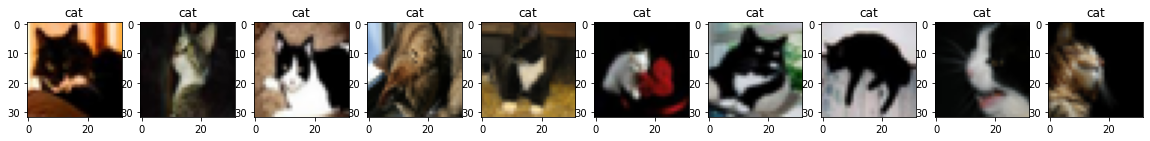

opponents:


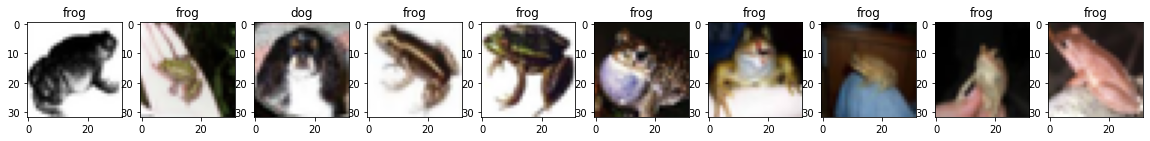

test example:
true_class: ship
predicted_class: ship
predicted_prob tensor(0.5685, grad_fn=<UnbindBackward>)


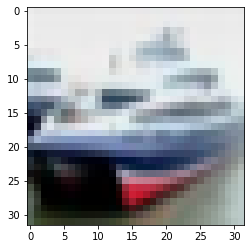

proponents:


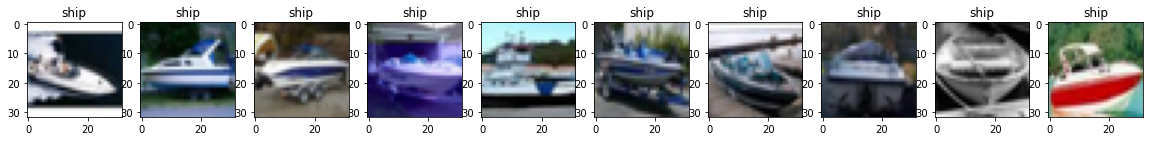

opponents:


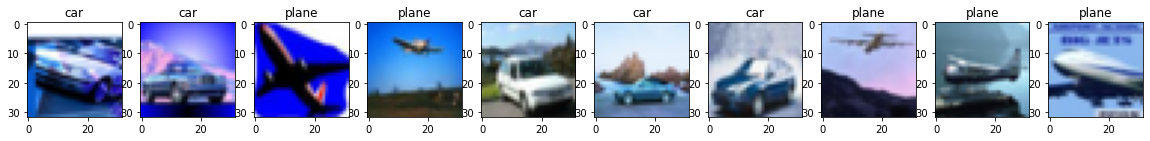

test example:
true_class: ship
predicted_class: ship
predicted_prob tensor(0.3574, grad_fn=<UnbindBackward>)


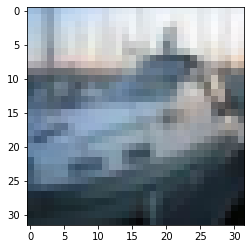

proponents:


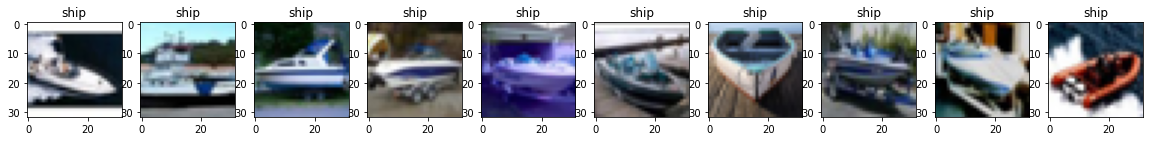

opponents:


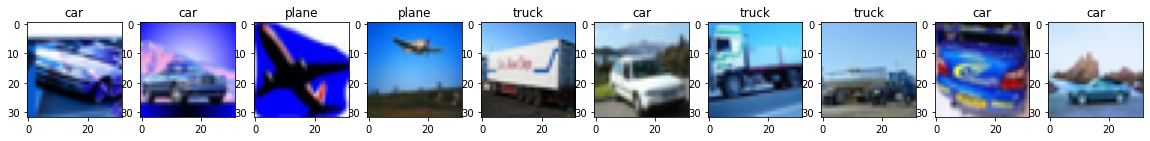

test example:
true_class: plane
predicted_class: ship
predicted_prob tensor(0.6398, grad_fn=<UnbindBackward>)


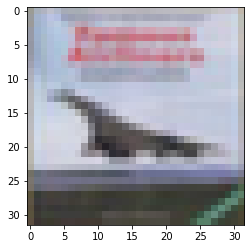

proponents:


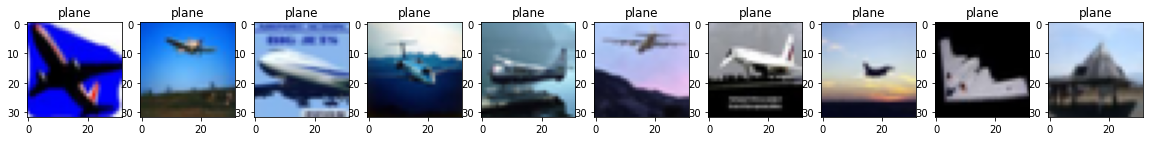

opponents:


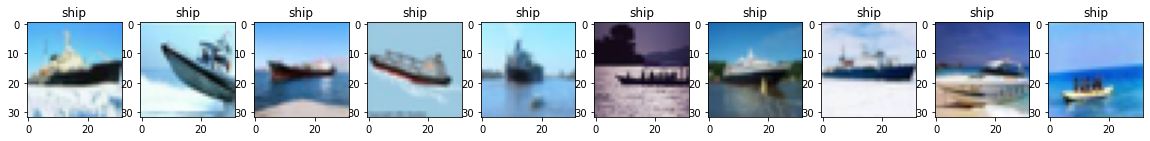

In [18]:
display_proponents_and_opponents(
    test_examples_batch,
    proponents_indices,
    opponents_indices,
    test_examples_true_labels,
    test_examples_predicted_labels,
    test_examples_predicted_probs,
)

We see that the results make intuitive sense.  For example, the proponents of a test example that is a cat are all cats, labelled as cats.  On the other hand, the opponents are all animals that look somewhat like cats, but are labelled as being other animals (i.e. dogs).  Thus the presence of these opponents drives the prediction on the test example away from cat.

#### Defining the `TracInCPFastRandProj` instance
We also define and use a `TracInCPFastRandProj` instance to show its pros and cons.
Note that `__init__` has 2 new arguments, due to the fact `TracInCPFastRandProj` stores embeddings related to each example in the training dataset in a nearest-neighbors data structure.  
- `nearest_neighbors`: This is a nearest-neighbors class used internally to find proponents / opponents quickly (proponents / opponents of a test example are those whose embeddings of a certain kind are similar / dissimilar to those of the text sample, see the TracIn paper for more details).  Currently, only a single nearest-neighbors class is offered: `AnnoyNearestNeighbors`, which wraps the Annoy library.  This class has a single argument: `num_trees`.  The number of trees to use. Increasing this number gives more accurate computation of nearest neighbors, but requires longer setup time to create the trees, as well as memory.
- `projection_dim`: The embeddings may be too high-dimension and require too much memory.  Random projections can be used to reduce the dimension of those embeddings.  This argument specifies that dimension (it corresponds to the `d` variable in Page 15 of the Appendix of the TracIn paper).  In more detail, the embedding is the concatenation of several "checkpoint-embeddings", each of which corresponds to a particular checkpoint.  Therefore, the dimension of the embedding is actually `projection_dim` times the number of checkpoints used.

***Note***: initialization will take ~10 minutes, so feel free to skip the tutorial parts related to `TracInCPFastRandProj`

In [19]:
from captum.influence._utils.nearest_neighbors import AnnoyNearestNeighbors
start_time = datetime.datetime.now()
tracin_cp_fast_rand_proj = TracInCPFastRandProj(
    model=net,
    final_fc_layer=list(net.children())[-1],
    influence_src_dataset=correct_dataset,
    checkpoints=correct_dataset_checkpoint_paths,
    checkpoints_load_func=checkpoints_load_func,
    loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    batch_size=128,
    nearest_neighbors=AnnoyNearestNeighbors(num_trees=100),
    projection_dim=100,
)
total_minutes = (datetime.datetime.now() - start_time).total_seconds() / 60.0
print(
    "Performed pre-processing of a dataset of %d examples in %.2f minutes"
    % (len(correct_dataset), total_minutes)
)

Performed pre-processing of a dataset of 50000 examples in 5.92 minutes


#### Compute the proponents / opponents using `TracInCPFastRandProj`
As before, we can compute the proponents / opponents using the `influence` method of this `TracInCPFastRandProj` instance.  Unlike the `TracInCPFast` instance, this computation should be very fast, due to the preprocessing done during initialization.

In [20]:
k = 10
start_time = datetime.datetime.now()
proponents_indices, proponents_influence_scores = tracin_cp_fast_rand_proj.influence(
    test_examples_batch, test_examples_true_labels, k=k, proponents=True
)
opponents_indices, opponents_influence_scores = tracin_cp_fast_rand_proj.influence(
    test_examples_batch, test_examples_true_labels, k=k, proponents=False
)
total_minutes = (datetime.datetime.now() - start_time).total_seconds() / 60.0
print(
    "Computed proponents / opponents over a dataset of %d examples in %.2f minutes"
    % (len(correct_dataset), total_minutes)
)

Computed proponents / opponents over a dataset of 50000 examples in 0.01 minutes


#### Display results
We can display, for each test example, its proponents and opponents

test example:
true_class: cat
predicted_class: cat
predicted_prob tensor(0.4126, grad_fn=<UnbindBackward>)


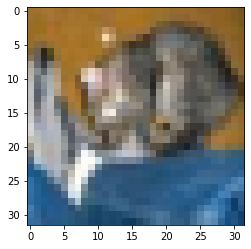

proponents:


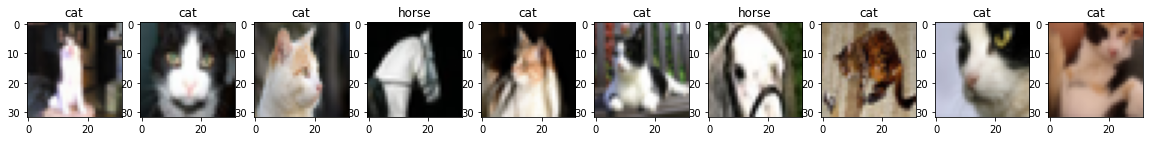

opponents:


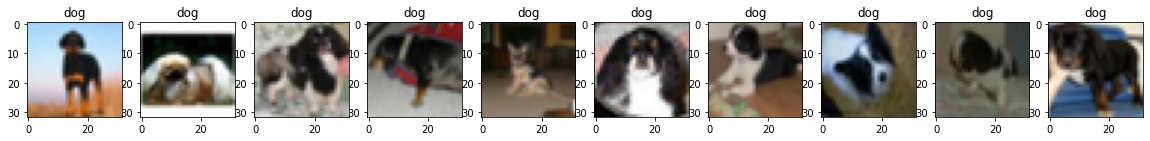

test example:
true_class: ship
predicted_class: ship
predicted_prob tensor(0.5685, grad_fn=<UnbindBackward>)


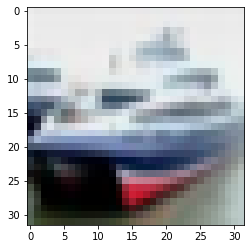

proponents:


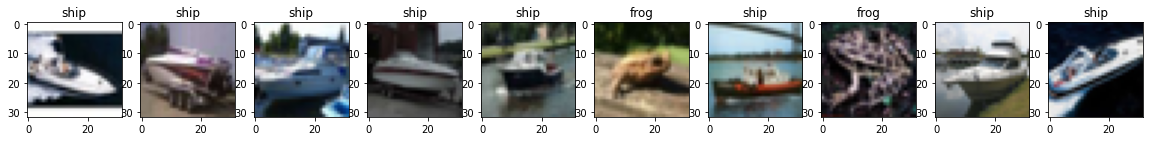

opponents:


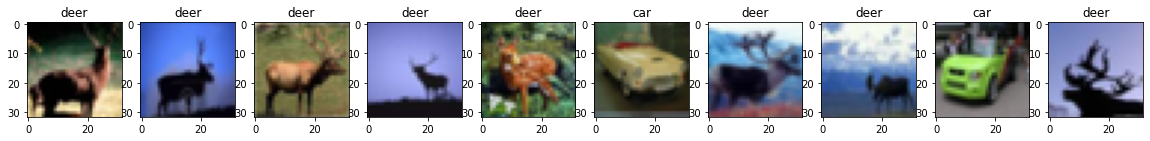

test example:
true_class: ship
predicted_class: ship
predicted_prob tensor(0.3574, grad_fn=<UnbindBackward>)


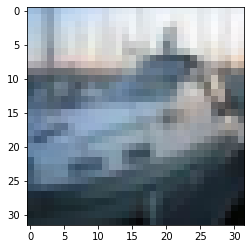

proponents:


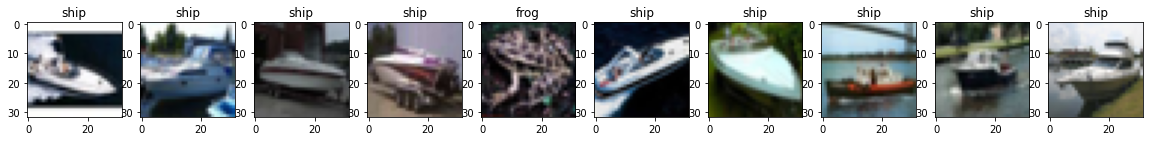

opponents:


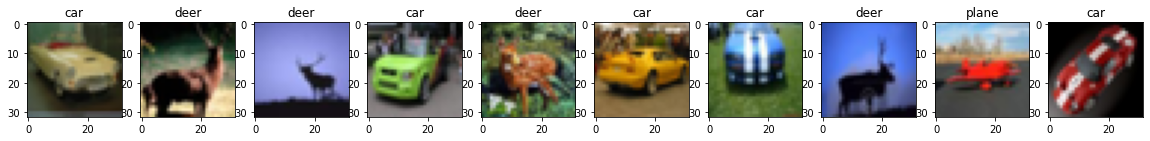

test example:
true_class: plane
predicted_class: ship
predicted_prob tensor(0.6398, grad_fn=<UnbindBackward>)


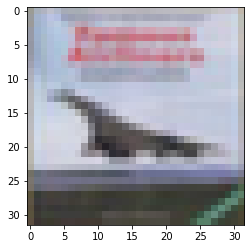

proponents:


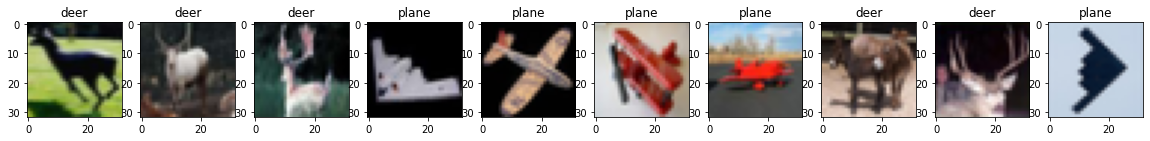

opponents:


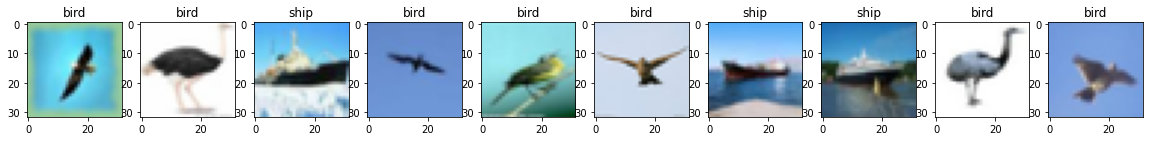

In [21]:
display_proponents_and_opponents(
    test_examples_batch,
    proponents_indices,
    opponents_indices,
    test_examples_true_labels,
    test_examples_predicted_labels,
    test_examples_predicted_probs,
)

We see that the proponents / opponents are not the same as before, but they are still reasonable.

# Identifying mislabelled data
Now, we will illustrate the ability of TracInCP to identify mislabelled data.  As before, we need 3 components:
- a Pytorch model.  We will continue to use `net`
- a Pytorch `Dataset` used to train `net`, `mislabelled_dataset`.
- A Pytorch `Dataset`, `test_dataset`.  For this, we will use the original CIFAR-10 validation split.  Unlike when using TracInCP to identify influential examples for certain test examples, we only use this for monitoring training; we are just identifying mislabelled examples in the training data.  Also note that unlike `mislabelled_dataset`, `test_dataset` will not have mislabelled examples.
- checkpoints from training `net` with `mislabelled_dataset`

#### Define `net`
We need to initialize `net` again, because currently, `net` is loaded with the parameters from training using `correct_dataset`, but we now want to train `net` from scratch using `mislabelled_dataset`.

In [22]:
net = Net()

#### Define `mislabelled_dataset`

We now define `mislabelled_dataset` by artificially introducing mis-labelled examples into `correct_dataset`.  Using artificial data lets us know the ground-truth for whether examples really are mis-labelled, and thus do evaluation. We create `mislabelled_dataset` from `correct_dataset` using the following procedure: We initialize the Pytorch model, trained using `correct_dataset`, as `correct_dataset_net`.  For 10% of the examples in `correct_dataset`, we use `correct_dataset_net` to predict the probability the example belongs to each class.  We then change the label to the most probable label that is *incorrect*.

Note that to know the ground truth for which examples in `mislabelled_dataset` are mislabelled, we can compare the labels between `mislabelled_dataset` and `correct_dataset`.  Also note that since both datasets have the same features, `mislabelled_dataset` is defined in terms of `correct_dataset`.

First, we initialize `correct_dataset_net`, loading the parameters from training using `correct_dataset` (we will use the last checkpoint from before, `correct_dataset_final_checkpoint`).

In [23]:
correct_dataset_net = Net()
checkpoints_load_func(correct_dataset_net, correct_dataset_final_checkpoint)

1.0

Then, we generate both incorrect labels and extract correct labels for every example in `correct_dataset`.  We need the correct labels since some of the examples in `incorrect_dataset` will still be correctly labelled.  This should take < 10 minutes.

In [24]:
start_time = datetime.datetime.now()
incorrect_labels = []
correct_labels = []
correct_dataset_dataloader = DataLoader(correct_dataset, batch_size=128, shuffle=False)
for i, (batch_features, batch_correct_labels) in enumerate(correct_dataset_dataloader):
    # get predicted probabilities of each class
    batch_predictions = torch.nn.functional.softmax(correct_dataset_net(batch_features), dim=1)
    # set the predicted probability of the correct class to 0
    batch_predictions[torch.arange(0, len(batch_predictions)), batch_correct_labels] = 0
    # most probable incorrect label is the remaining class with the highest predicted probability
    batch_incorrect_labels = torch.argmax(batch_predictions, dim=1)
    incorrect_labels.append(batch_incorrect_labels)
    correct_labels.append(batch_correct_labels)

incorrect_labels = torch.cat(incorrect_labels)
correct_labels = torch.cat(correct_labels)

total_minutes = (datetime.datetime.now() - start_time).total_seconds() / 60.0
print("Generated incorrect labels in %.2f minutes" % total_minutes)

Generated incorrect labels in 0.52 minutes


Now, we create the labels for `mislabelled_dataset`.  10% will come from `incorrect_labels`, and the remaining from `correct_labels`

In [25]:
mislabelled_proportion = 0.10
use_incorrect = torch.rand(len(incorrect_labels)) < mislabelled_proportion
mislabelled_dataset_labels = (use_incorrect * incorrect_labels) + ((~use_incorrect) * correct_labels)

Finally, define `mislabelled_dataset`, which will depend on `correct_dataset`, as they share features

In [26]:
class MislabelledDataset(Dataset):
    def __init__(self, correct_dataset: Dataset, mislabelled_dataset_labels: torch.Tensor):
        self.correct_dataset, self.mislabelled_dataset_labels = correct_dataset, mislabelled_dataset_labels

    def __getitem__(self, i):
        return self.correct_dataset[i][0], self.mislabelled_dataset_labels[i]

    def __len__(self):
        return len(self.correct_dataset)

mislabelled_dataset = MislabelledDataset(correct_dataset, mislabelled_dataset_labels)

We can now extract the ground-truth of whether examples in `mislabelled_dataset` are mislabelled by comparing the labels extracted from `mislabelled_dataset` with those extracted from `correct_dataset`, and verify that indeed ~10% of examples in `mislabelled_dataset` are mislabelled.  This ground-truth is saved as `is_mislabelled`, and will be used later for evaluation.

In [27]:
_incorrect_dataset_labels = torch.Tensor([mislabelled_dataset[i][1] for i in range(len(mislabelled_dataset))])
_correct_dataset_labels = torch.Tensor([correct_dataset[i][1] for i in range(len(correct_dataset))])
is_mislabelled = _incorrect_dataset_labels != _correct_dataset_labels
print("%.2f percent of the labels in `incorrect_dataset` are mislabelled." % (100 * torch.mean(is_mislabelled.float())))

10.01 percent of the labels in `incorrect_dataset` are mislabelled.


#### Define the set of checkpoints
To detect mislabelled examples in `mislabelled_dataset`, we need to first train a model using `mislabelled_dataset`, and save the checkpoints.  We will train `net` for 101 epochs on `mislabelled_dataset`.

We first define the folder to save checkpoints in.  We will need this folder later to run a TracInCP algorithm.

In [28]:
mislabelled_dataset_checkpoints_dir = os.path.join("checkpoints", "cifar_10_mislabelled_dataset")

Finally, we train the model, converting `mislabelled_dataset` and `test_dataset` into `DataLoader`s, and saving every 20-th checkpoint.
For this tutorial, we have saved the checkpoints from this training on AWS S3, and you can just download those checkpoints instead of doing time-intensive training.  If you want to do training yourself, please set the `do_training` flag in the next cell to `True`.

In [ ]:
num_epochs = 101
do_training = False # change to `True` if you want to do training
if do_training:
    train(net, num_epochs, DataLoader(mislabelled_dataset, batch_size=128, shuffle=True), DataLoader(test_dataset, batch_size=128, shuffle=True), mislabelled_dataset_checkpoints_dir, save_every=20)
elif not os.path.exists(mislabelled_dataset_checkpoints_dir):
    # this should download the zipped folder of checkpoints from the S3 bucket, 
    # then unzip the folder to produce checkpoints in the folder `checkpoints/cifar_10_mislabelled_dataset`
    # this is done if checkpoints do not already exist in the folder
    # if the below commands do not work, please manually download and unzip the folder to produce checkpoints in that folder
    os.makedirs(mislabelled_dataset_checkpoints_dir)
    !wget https://pytorch.s3.amazonaws.com/models/captum/influence-tutorials/cifar_10_mislabelled_dataset.zip -O checkpoints/cifar_10_mislabelled_dataset.zip
    !unzip -o checkpoints/cifar_10_mislabelled_dataset.zip -d checkpoints

We define the list of checkpoints, `mislabelled_dataset_checkpoint_paths`, to be all saved checkpoints from training.

In [31]:
mislabelled_dataset_checkpoint_paths = glob.glob(os.path.join(mislabelled_dataset_checkpoints_dir, "*.pt"))

#### Choosing the TracInCP algorithm to use
For the sake of this tutorial, to save time / memory, we will only consider gradients in the last fully-connected layer, and will not use `TracInCP`.  Because we will be calculating self influence scores, we should use `TracInCPFast` (recall `TracInCPFastRandProj` should not be used in self influence mode).

#### Defining the `TracInCPFast` instance
We now define the `TracInCPFast` instance.  Initialization should be instantaneous, as no pre-processing is done.  Note that we use the mislabelled dataset and checkpoints from training with it, i.e. `mislabelled_dataset` and `mislabelled_dataset_checkpoint_paths`

In [32]:
tracin_cp_fast = TracInCPFast(
    model=net,
    final_fc_layer=list(net.children())[-1],
    influence_src_dataset=mislabelled_dataset,
    checkpoints=mislabelled_dataset_checkpoint_paths,
    checkpoints_load_func=checkpoints_load_func,
    loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    batch_size=2048,
)

#### Calculating self influence scores
We can now calculate self influence for `incorrect_dataset`.  Note that the function call will have no arguments, because `incorrect_dataset` was already loaded during the initialization of `tracin_cp_fast`.  This should take several minutes.

In [33]:
start_time = datetime.datetime.now()
self_influence_scores = tracin_cp_fast.influence()
total_minutes = (datetime.datetime.now() - start_time).total_seconds() / 60.0
print('computed self influence scores for %d examples in %.2f minutes' % (len(self_influence_scores), total_minutes))

computed self influence scores for 50000 examples in 0.59 minutes


#### Evaluating ability of self influence scores to detect mis-labelled data
To evaluate the ability of TracInCP to identify mislabelled examples by calculating self influence scores, we want to answer the question "does ranking examples by self influence score (in descending order) tend to rank mislabelled examples before correctly-labelled samples?"
We can answer this by displaying the ROC curve from using self influence scores to identify mislabelled examples.  This is similar to how we display the ROC curve to measure performance when we use the predicted positive probability to identify true positives.
Recall that we have already calculated `is_mislabelled`, the ground-truth of whether each example is mislabelled.  Below is the ROC curve:

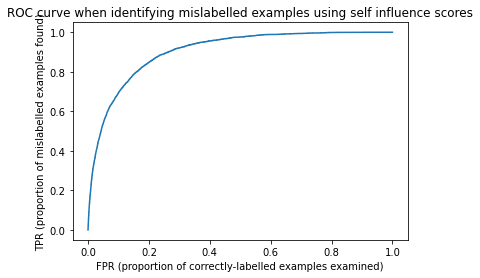

In [35]:
fpr, tpr, _ = roc_curve(is_mislabelled, self_influence_scores)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
fontsize = 10
ax.set_ylabel("TPR (proportion of mislabelled examples found)", fontsize=fontsize)
ax.set_xlabel("FPR (proportion of correctly-labelled examples examined)", fontsize=fontsize)
ax.set_title("ROC curve when identifying mislabelled examples using self influence scores")
fig.show()

We see that prioritizing by self influence scores tends to prioritize mislabelled examples over correctly-labelled examples.  Note that the performance (i.e. area under ROC curve) will be much better if we had used a better model, like resnet; the goal of this tutorial is just to demonstrate usage for TracInCP.